In [91]:
from moss.mosaic import Mosaic
import nibabel as nib
import multiprocessing
#os and i/o
import os
import numpy as np
import os.path as op
import seaborn as sns
import matplotlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [3]:
exp = 'sim_4mm-PEdiff'
masks = ['hipp']

In [33]:

all_rsas = []
for sub in subs:
    sub_path = op.abspath('./analysis/' + exp + '/' + sub + '/reg/epi/smoothed/')

    m = masks[0]
    mask = op.abspath('./data/' + sub + '/masks/' + m +'.nii.gz')
    mask = nib.load(mask).get_data().astype(bool)

    rsa = []
    for run in map(str,range(1,4)):
        run_dir = sub_path + '/run_'  + run
        
        if os.path.exists(run_dir):
            stats = []
            
            for i in [13,15,17,19]:
                f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'
                stat = nib.load(f).get_data().astype(float)
                stats.append(stat[mask])
                
            stats = np.array(stats)
            rsa.append(np.corrcoef(stats))
            
    rsa = np.array(rsa)
    all_rsas.append(np.mean(rsa,axis=0))


In [87]:
all_rsas = np.array(all_rsas)
mean_rsa = np.mean(all_rsas,axis=0)
mask = np.zeros_like(mean_rsa)
mask[np.triu_indices_from(mask)] = True

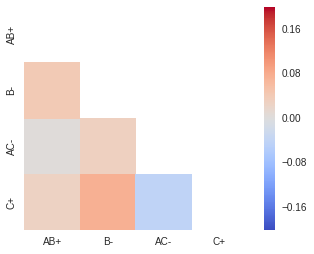

In [88]:
conds = ['AB+','B-','AC-','C+']
df = {'AB+': mean_rsa[:,0],
     'B-': mean_rsa[:,1],
     'AC-': mean_rsa[:,2],
     'C+': mean_rsa[:,3]}
df = pd.DataFrame(df,index = conds)
df.sort(columns = ['AB+','B-','AC-','C+'])
df = df[conds]

with sns.axes_style("white"):
    ax = sns.heatmap(df, mask = mask, vmax = .2, square = True, cmap = 'coolwarm')


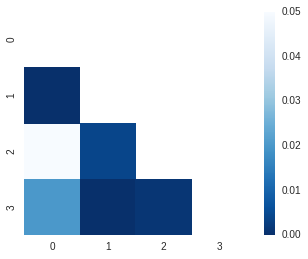

In [99]:
t,p = scipy.stats.ttest_1samp(np.arctanh(all_rsas),0)
with sns.axes_style("white"):
    ax = sns.heatmap(p, mask = mask, vmax = .05, square = True, cmap = 'Blues_r')